# ANN Notebook part 2 - Regression
## This notebook explores how to create, train \& optimize Artificial Neural Networks for regression 

### Part 1 is very detailed in its explanations. Much is the same when making ANNs for regression, and we will keep it brief.

........................................

### Main differences in ANN building for regression vs classification
1. $\textbf{The output layer activation function}$ \
    Regression: Often relu or linear \
    Classification: Often sigmoid or softmax
2.  $\textbf{The loss function function}$ \
    Regression: Often mean squared error, mean absolute percentage error or mean squared logarithmic error \
    Classification: Often binary cross entropy
3.  $\textbf{The additional metrics for evaluating performance}$ \
    Regression: Often mean squared error or mean absolute percentage error \
    Classification: Often accuracy or area under curve

........................................

### Goal:
Using the other features, we are going to predict the value of 'Value' for each data point, i.e. we are going to predict the price of each product sale.

******************
$\textit{Authors:}$ Nikolaj Krebs \& Simon Guldager \
$\textit{Date:}$ 18-09-2024


In [15]:
#pip install tensorflow

In [16]:
#pip install scikeras


In [17]:
#pip install keras

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import confusion_matrix and classification_report for model evaluation
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
# Import StandardScaler for feature scaling
from sklearn.preprocessing import StandardScaler, QuantileTransformer, normalize
# Import train_test_split for splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# Import permutation_importance for calculating feature importance  
from sklearn.inspection import permutation_importance


### Tensorflow and Keras imports ###

# Import TensorFlow for machine learning
import tensorflow as tf
# Import Keras for high-level neural networks API
from tensorflow import keras
# Import Dense and Activation layers for neural network architecture
from tensorflow.keras.layers import Dense, Activation
# Import Sequential for linear stacking of layers
from keras.models import Sequential
# Import KerasClassifier to make Keras models compatible with scikit-learn
from scikeras.wrappers import KerasClassifier, KerasRegressor


# set print options for pandas
pd.set_option('display.max_columns', None)

## some stuff for making pretty plots
from matplotlib import rcParams
from cycler import cycler
## Set plotting style and print options
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster
# Set figure format
wide_format, square_format = False, True
if wide_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.figsize': (9,6)}
if square_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,\
     'legend.fontsize': 12, 'font.family': 'serif', 'figure.figsize': (6,6)}
    
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)

Useful functions for plotting and evaluating the model

In [78]:
def plot_evaluation_results(history):

    # make a list of the train and val metrics
    metrics = list(history.history.keys())
    
    # make lists of train and val metrics
    val_metrics = [entry for entry in metrics if entry.startswith('val_')]
    train_metrics = [entry for entry in metrics if not entry.startswith('val_')]

    # the number of metrics to plot
    Nmetrics = len(val_metrics)
    width = 6 * Nmetrics

     # plot the train and val results for each metric
    fig, ax = plt.subplots(ncols = Nmetrics, figsize=(width, 6))
    for i, axx in enumerate(ax):
        axx.plot(history.history[train_metrics[i]], label='train', alpha = 0.7)  
        axx.plot(history.history[val_metrics[i]], label='validation', alpha = 0.7)
        axx.set_ylabel(f'{train_metrics[i].capitalize()}')
        axx.set_xlabel('Epoch')
        axx.legend(loc='best')
    fig.tight_layout()
    return fig, ax 

def evaluate_regression_results(model, X_train, y_train, X_val, y_val, X_test = None, y_test = None,\
                                           metrics = [r2_score, mean_absolute_error], metric_names = ['r2', 'MAE']):
    
    # make predictions
    y_pred_train = model.predict(X_train, verbose = 0)   
    y_pred_val = model.predict(X_val, verbose = 0)

    # if test data is provided, make predictions
    if X_test is not None and y_test is not None:
        y_pred_test =  model.predict(X_test, verbose = 0)

    # calculate metrics
    for metric, metric_name in zip(metrics, metric_names):
        metric(y_train, y_pred_train.round())
        print(f'{metric_name} on training data: {metric(y_train, y_pred_train.round()):.3f}')
        print(f'{metric_name} on validation data: {metric(y_val, y_pred_val.round()):.3f}')
        if X_test is not None and y_test is not None:
            print(f'{metric_name} on test data: {metric(y_test, y_pred_test.round()):.3f}')
    return

Load the sales insight data. 

In [16]:
df = pd.read_csv('data_processed/sales_insights_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7282 entries, 0 to 7281
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Account Description      7282 non-null   object 
 1   Size                     7282 non-null   object 
 2   Size Numeric             7282 non-null   float64
 3   Strength (mg)            7282 non-null   float64
 4   WHO ATC 5 Code           7282 non-null   object 
 5   Volume                   7282 non-null   float64
 6   Value                    7282 non-null   float64
 7   Year Month (after 2000)  7282 non-null   float64
 8   Year (after 2000)        7282 non-null   float64
 9   Month                    7282 non-null   float64
 10  Region_Færøerne          7282 non-null   bool   
 11  Region_Hovedstaden       7282 non-null   bool   
 12  Region_Midtjylland       7282 non-null   bool   
 13  Region_Nordjylland       7282 non-null   bool   
 14  Region_Sjælland         

Let's have a look at the WHO ATC 5 values

In [69]:
# set the target column for regression
target_col = 'Value'

# represent the ATC code with a number (if not already done)
if df['WHO ATC 5 Code'].dtype == 'object':
    atc_code_rep = {'L04AC05': 0, 'L04AB02': 1, 'L04AB05': 2, }
    df['WHO ATC 5 Code'] = df['WHO ATC 5 Code'].map(atc_code_rep).astype(int)

df['WHO ATC 5 Code'].value_counts()

WHO ATC 5 Code
0    3713
1    2259
2    1310
Name: count, dtype: int64

In [22]:
# find all columns starting with 'Product'
product_columns = [col for col in df.columns if 'Product' in col]
product_columns

['Product_Cimzia',
 'Product_Inflectra',
 'Product_Remicade',
 'Product_Remsima',
 'Product_Stelara',
 'Product_Zessly']

Let's decide the columns to use for regression

In [131]:
# choose columns to drop from the dataset
num_cols_to_drop = [target_col]  #['Year Month (after 2000)', 'Strength (mg)', 'Size Numeric']
# add product columns to the list of columns to drop
#num_cols_to_drop.extend(product_columns)

# get all numerical columns
num_cols = list(df.select_dtypes(include=['float', 'bool']).columns)
# remove columns to drop from the list of numerical columns
cols_to_use_for_regression = [col for col in num_cols if col not in num_cols_to_drop]

cols_to_use_for_regression

['Size Numeric',
 'Strength (mg)',
 'Volume',
 'Year Month (after 2000)',
 'Year (after 2000)',
 'Month',
 'Region_Færøerne',
 'Region_Hovedstaden',
 'Region_Midtjylland',
 'Region_Nordjylland',
 'Region_Sjælland',
 'Region_Syddanmark',
 'Product_Cimzia',
 'Product_Inflectra',
 'Product_Remicade',
 'Product_Remsima',
 'Product_Stelara',
 'Product_Zessly']

# Correlation Matrix

Let's compute the correlation matrix for the features to use for classification along with the target column

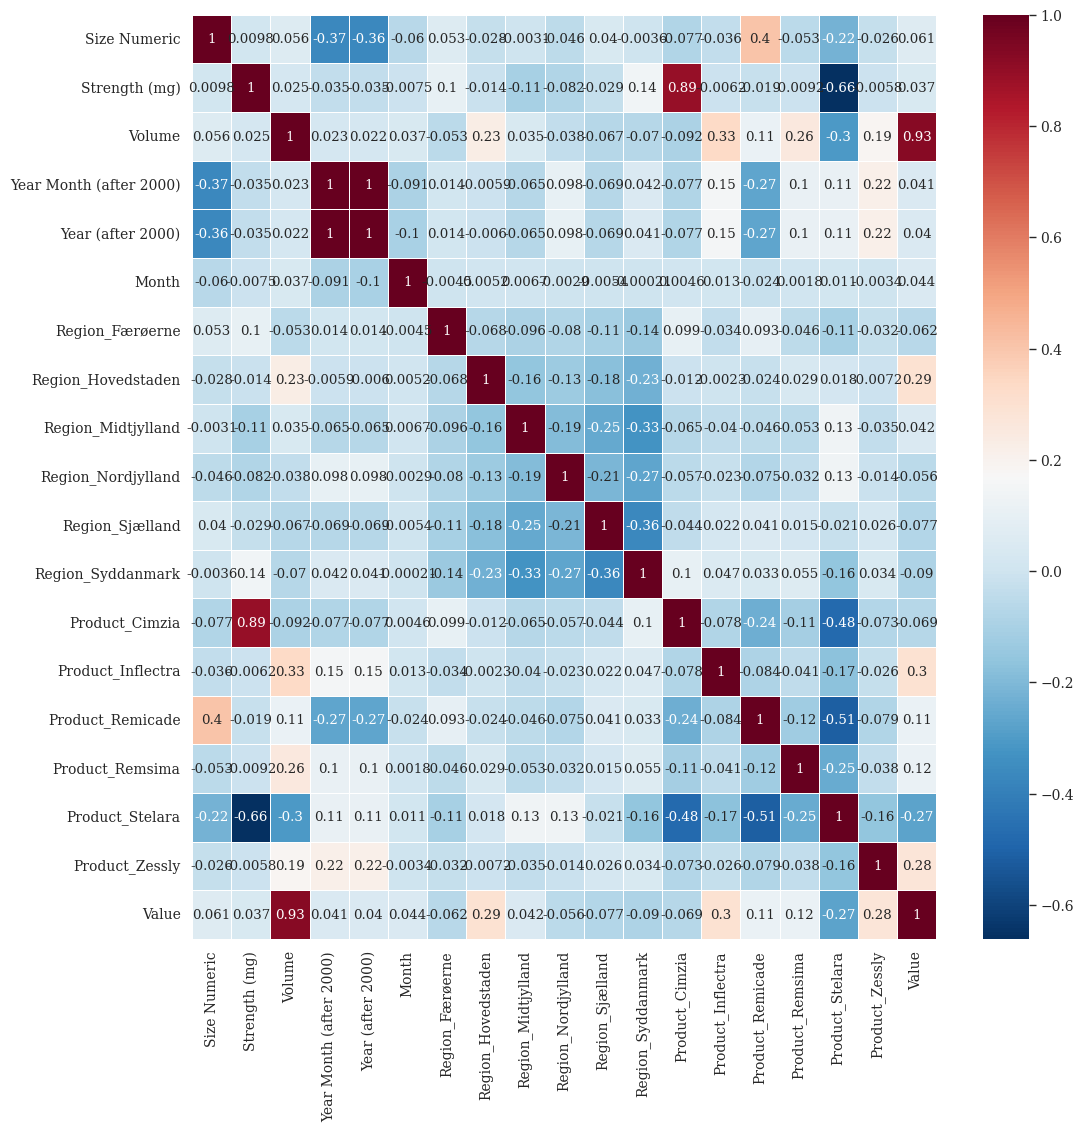

In [132]:
#### Compute the pairwise Pearson correlation matrix for df.

# The Pearson correlation coefficient measures the linear relationship between two variables.
# Its value ranges from -1 to 1, where:
# - 1 implies a perfect positive linear relationship,
# - -1 implies a perfect negative linear relationship, and
# - 0 implies no linear relationship.

corr = df[cols_to_use_for_regression + [target_col]].corr(method='pearson')

# Create a new figure and axis with a specified size.
# Adjust the figsize values to change the size of each cell in the heatmap.
fig, ax = plt.subplots(figsize=(12, 12))

# Create a heatmap using Seaborn.
# - `corr`: The computed correlation matrix.
# - `xticklabels` & `yticklabels`: Use the columns of the correlation matrix for labeling the x and y axis respectively.
#   blue represents positive correlations and red represents negative correlations.
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r', annot=True, linewidth=0.5, ax=ax);

### Data data transformation \& splitting

.. for simplicity, we will only consider the data corresponding to 1 of the medicine types

In [133]:
mask = df['WHO ATC 5 Code'] == 0

# Split the dataset into features and target variable
df_X = df[mask][cols_to_use_for_regression]
df_y = pd.DataFrame(data = df[mask][target_col], columns = [target_col])

# Initialize the StandardScaler object
# StandardScaler standardizes the dataset by setting the mean to 0 and variance to 1
scaler = StandardScaler()

# Fit and transform the independent data features
X = scaler.fit_transform(df_X)
y = df_y.values.ravel()

print("Independent variables:",cols_to_use_for_regression)
print("Dependent variable:",target_col)
print("Shape of independent features:", X.shape)
print("Shape of target variable:", y.shape)

Independent variables: ['Size Numeric', 'Strength (mg)', 'Volume', 'Year Month (after 2000)', 'Year (after 2000)', 'Month', 'Region_Færøerne', 'Region_Hovedstaden', 'Region_Midtjylland', 'Region_Nordjylland', 'Region_Sjælland', 'Region_Syddanmark', 'Product_Cimzia', 'Product_Inflectra', 'Product_Remicade', 'Product_Remsima', 'Product_Stelara', 'Product_Zessly']
Dependent variable: Value
Shape of independent features: (3713, 18)
Shape of target variable: (3713,)


In [134]:
# Set the fraction of data to be used for test data
test_size = 0.15

## Split training data into training-validation and test data for classification
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Split training data into training and validation data for classification
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_size, random_state=42)

print('X_train.shape:',X_train.shape)
print('X_val.shape:',X_val.shape)
print('X_test.shape:',X_test.shape)
print('y_train.shape:',y_train.shape)
print('y_val.shape:',y_val.shape)
print('y_test.shape:',y_test.shape)

X_train.shape: (2682, 18)
X_val.shape: (474, 18)
X_test.shape: (557, 18)
y_train.shape: (2682,)
y_val.shape: (474,)
y_test.shape: (557,)


## Building a neural network

#### Step 1: Create the model

In [149]:
### Create an instance of a Keras Sequential model.
# Sequential models are appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model = keras.models.Sequential()

### Add layers to the model.
# Add an Input layer to the model.
# The 'shape' argument specifies the shape of the input data, which here matches the number of features in X_train.
model.add(keras.layers.Input(shape=X_train.shape[1]))

# Add the first hidden layer with e.g. 15 units and ReLU (Rectified Linear Unit) activation function.
# ReLU activation function replaces all negative values in the output with zero.
model.add(keras.layers.Dense(15, activation='relu'))

# Add the second hidden layer with e.g. 20 units and ReLU activation function.
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))

# Add the output layer with a single unit and a sigmoid activation function.
# The linear function is often used in the output layer for regression problems.
# It squashes the output to lie in the range of 0 to 1, which can be interpreted as probabilities.
model.add(keras.layers.Dense(1, activation='linear'))
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 15)                285       
                                                                 
 dense_21 (Dense)            (None, 20)                320       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1046 (4.09 KB)
Trainable params: 1046 (4.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Step 2: Compile the model

In [150]:
# Compile the model with the necessary attributes.
# - loss function: 'binary_crossentropy' is commonly used for binary classification problems.
# - optimizer: 'adam' is a popular optimization algorithm that is an extension of stochastic gradient descent.
# - learning rate: how quickly the model updates it weights. A large learning rate causes the model to adapt more quickly,
#                  but at the cost of stability
# - metrics: 'accuracy' is used to evaluate the model (but there are many good choices).

# Compile the model with the necessary attributes and the default learning rate.
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), \
              metrics=[tf.keras.metrics.LogCoshError()])

#### Step 3: Fit the model to the training data

In [151]:
# batch_size: the number of samples that will be propagated through the network. a smaller batch size will take longer to train,
#             but will be more accurate. A larger batch size will train faster, but will be less accurate.
# epochs: the number of times the model will cycle through the data. A larger number of epochs will take longer to train,

history = model.fit(X_train, y_train, batch_size=128, epochs=125, validation_data=(X_val, y_val), verbose=0)

#### Step 4: Evaluate the model performance on the training and validation data

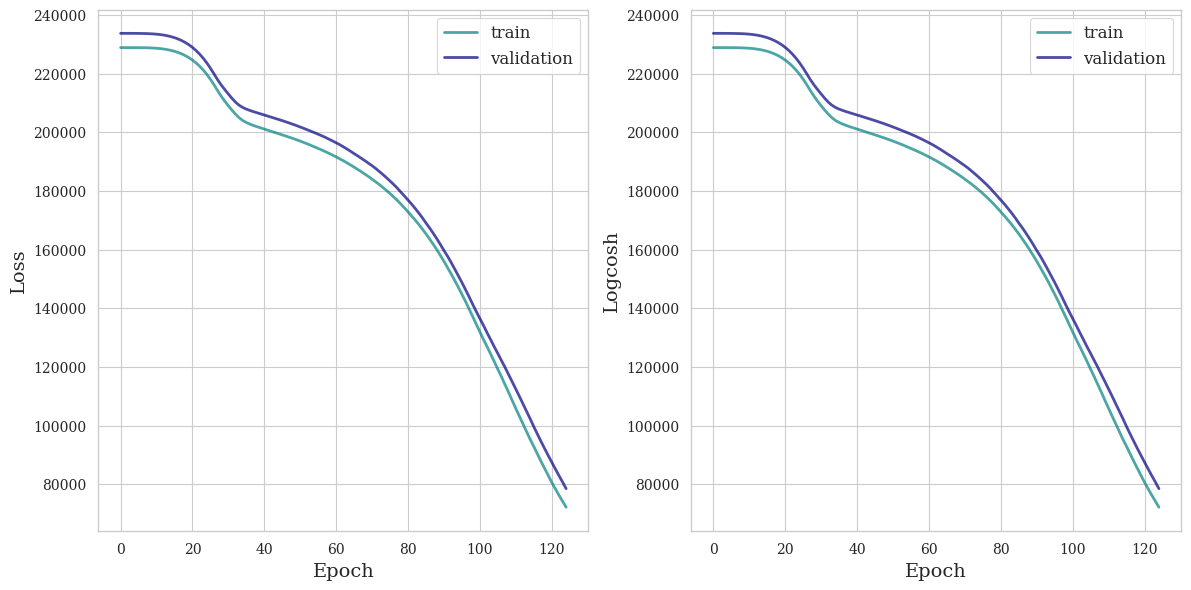

In [154]:
plot_evaluation_results(history);

In [141]:
# define a function to calculate the relative error
def relative_error(y_true, y_pred):
    zero_mask = y_true != 0
    return np.nanmean(np.abs((y_true[zero_mask] - y_pred[zero_mask]) / y_true[zero_mask]))

In [158]:
evaluate_regression_results(model, X_train, y_train,\
                     X_val, y_val,\
                          metrics = [relative_error, r2_score,], metric_names = ['Mean relative error', 'r2',])

Mean relative error on training data: 0.832
Mean relative error on validation data: 0.857
r2 on training data: 0.909
r2 on validation data: 0.889


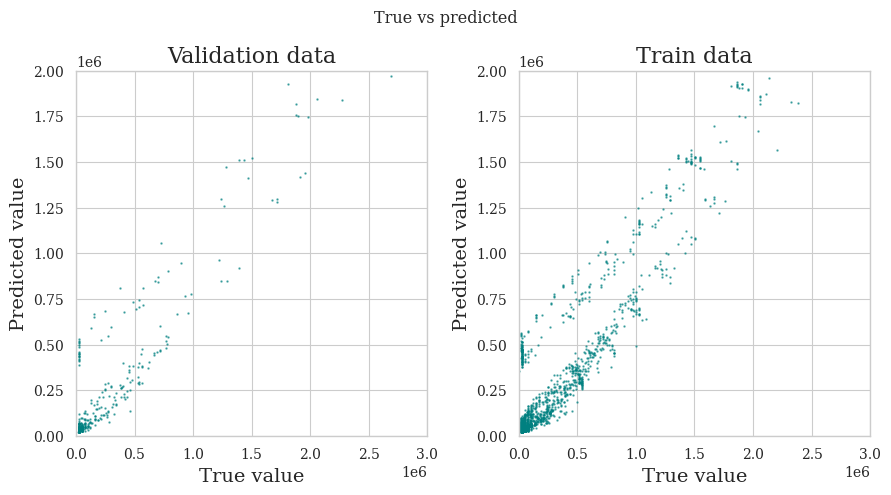

In [162]:
## Visualize the predictions
y_pred_train = model.predict(X_train, verbose = 0)
y_pred_val = model.predict(X_val, verbose = 0)

fig, ax = plt.subplots(ncols=2, figsize=(9,5))
ax = ax.flatten()
fig.suptitle(f'True vs predicted')
ax[0].plot(y_val, y_pred_val, '.', markersize = 1.5, alpha = .6)
ax[0].set(xlabel = 'True value', ylabel = 'Predicted value', title = 'Validation data', ylim=[0,2e6], xlim=[0,3e6])
ax[1].plot(y_train, y_pred_train, '.', markersize = 1.5, alpha = .6)
ax[1].set(xlabel = 'True value', ylabel = 'Predicted value', title = 'Train data', ylim=[0,2e6], xlim = [0,3e6]);
fig.tight_layout()

We see that our model has still much to learn! Below is the model for creating models for regression for convenience

In [165]:
# Define a function named 'create_model' that takes 'layers' and 'learning_rate' as parameters.
def create_model(layers, learning_rate):
    # Initialize an empty Sequential model.
    model = Sequential()

    # Loop through the list of layers specified in the 'layers' parameter.
    # The 'enumerate' function returns both the index 'i' and the value 'nodes' of each layer.
    for i, nodes in enumerate(layers):
        # If it's the first layer (i == 0), add an input dimension.
        if i == 0:
            model.add(keras.layers.Dense(nodes, input_dim = X_train.shape[1], activation='relu'))
        # For subsequent layers, no need to specify the input dimension.
        else:
            model.add(keras.layers.Dense(nodes, activation='relu'))

    # Add the output layer with a single unit (binary classification). 
    model.add(keras.layers.Dense(1, activation='linear'))

    print(model.summary())

    # Compile the model with the 'adam' optimizer and 'binary_crossentropy' loss function.
    # Metrics used for evaluation is accuracy.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.MeanAbsoluteError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    # Return the compiled model.
    return model

*************************************

# Exercises 

### Exercise 1: 

Go through this notebook step by step and make sure you understand the differences between regression and classification when building neural networks

### Exercise 2: 

Using the feature importance code from the classification notebook, calculate the relative importance of features and drop those you deem unimportant. Retrain the model. Was the model performance affected?

### Exercise 3:

1. Choose your favorite combination of hyperparameters - train and evaluate your model (using the hyperparameter tuning code from the classification notebook). Can you do better than our previous model in terms of the relative error and $R^2$ value on the train and validation data?
2. Use hyperparameter choosing to optimize one or more hyperparameters. Did the performance improve?
3. Once you have finished training and optimizing your model, make predictions on the test data


